# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import copy

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    tnsfm=transforms.Compose([transforms.Resize((image_size,image_size)),
                              transforms.ToTensor(),
                             ])

    
    return torch.utils.data.DataLoader(datasets.ImageFolder(data_dir,transform=tnsfm),batch_size=batch_size,shuffle=True)


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

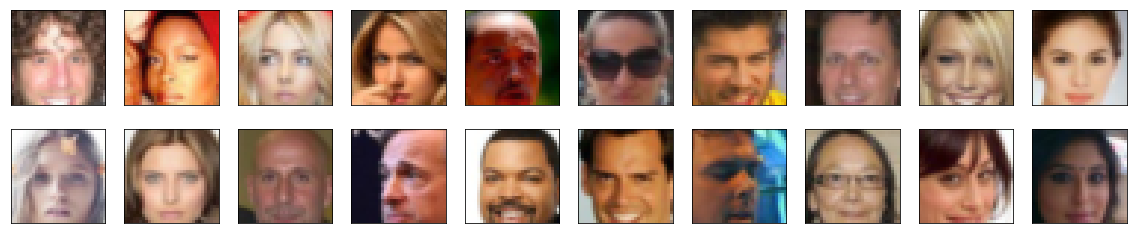

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=min(20,batch_size)
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    return x*(feature_range[1]-feature_range[0])+feature_range[0]


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8510)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        
        self.conv1=nn.Conv2d(conv_dim,conv_dim,3,1,1)
        self.bn1=nn.BatchNorm2d(conv_dim)
        self.conv2=nn.Conv2d(conv_dim,conv_dim,3,1,1)
        self.bn2=nn.BatchNorm2d(conv_dim)
        self.act=nn.ReLU()
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)       
        
        return self.act( x + self.bn2( self.conv2( self.act( self.bn1(self.conv1(x)) ) ) ) )

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim, n_res=4):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3,conv_dim,4,2,1) # 16,16,64
        
        self.res0 = ResidualBlock(conv_dim)
        
        self.conv2 = nn.Conv2d(conv_dim,conv_dim*2,4,2,1,bias=False) # 8,8,128
        self.bn2 = nn.BatchNorm2d(conv_dim*2)
        
        res=[]
        for _ in range(n_res):
            res.append(ResidualBlock(conv_dim*2))
        self.res = nn.Sequential(*res)
        
        self.conv3 = nn.Conv2d(conv_dim*2,conv_dim*4,4,2,1,bias=False) # 4,4,256
        self.bn3 = nn.BatchNorm2d(conv_dim*4)
        
        self.conv4 = nn.Conv2d(conv_dim*4,1,4,1,0) # 1,1,1
        
        self.act=nn.LeakyReLU(negative_slope=0.2)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = self.act(self.conv1(x))
        x = self.res0(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.res(x)
        x = self.act(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        
        return nn.Sigmoid()(x.squeeze(3).squeeze(2))
        # I realize that we omitted this final sigmoid activation in some of the mini-projects
        # But I'm not sure why. It seems like we need to squash D to (0,1) for things to make sense...


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim, n_res=1):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        
        self.z_size_sliced = z_size - z_size%16
        if z_size%16 != 0:
            print("Warning: The last few components of z vectors will always get dropped by this model.\nYou should make z_size a multiple of 16\n")
            

        self.first_channels = self.z_size_sliced//16 # number of channels in first conv layer
        
        self.conv0 = nn.Conv2d(self.first_channels,conv_dim*4,3,1,1,bias=False)
        self.bn0 = nn.BatchNorm2d(conv_dim*4)
        
        
        res=[]
        for _ in range(n_res):
            res.append(ResidualBlock(conv_dim*4))
        self.res1 = nn.Sequential(*res)
        
        self.conv1 = nn.ConvTranspose2d(conv_dim*4,conv_dim*2,4,2,1,bias=False)
        self.bn1 = nn.BatchNorm2d(conv_dim*2)
        
        res=[]
        for _ in range(n_res):
            res.append(ResidualBlock(conv_dim*2))
        self.res2 = nn.Sequential(*res)
        
        self.conv2 = nn.ConvTranspose2d(conv_dim*2,conv_dim,4,2,1,bias=False)
        self.bn2 = nn.BatchNorm2d(conv_dim)
        
        self.conv3 = nn.ConvTranspose2d(conv_dim,3,4,2,1)
        
        self.act=nn.ReLU()
        self.final_act=nn.Tanh()

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """

        x = x.narrow(1,0,self.z_size_sliced)
        x = x.view(-1,self.first_channels,4,4)
        x = self.act(self.bn0(self.conv0(x)))

        x = self.res1(x)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.res2(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.final_act(self.conv3(x))
        
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

You should make z_size a multiple of 16

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # This is how I would initialize weights as described above:
#     if classname in ['Conv2d' or 'ConvTranspose2d']:
#         m.weight.data.normal_(0,0.02)
    
    # Please see cell below to understand why I chose to pass on custom weight initalization.
    
    

I chose not to implement this custom weight initialization, because I'm actually more willing to trust the default weight initialization instead. In the DCGAN paper linked above, the authors don't really give a convincing reason for their choice of weight initialization. It might be that they just wanted to make their results simple for others to reproduce, which is great but not necessary for me here.

The [documentation](https://pytorch.org/docs/stable/nn.html#conv2d) says that initial convolultional kernel tensor entries will be pulled from a uniform distribution $U(-\sqrt{k},\sqrt{k})$ where
$$ k = \frac{1}{\text{num_channels}\times\text{kernel_size}^2}. $$
I'm more comfortable with this because it's the [tried and true](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) standard weight initialization, and also it's not so different from the one in the DCGAN paper in typical situations. For example with 128 channels and $4\times 4$ kernel, we have $\sqrt{k}\approx 0.022$.

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (res0): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

run_id = '13'

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr=2e-4,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(),lr=2e-4,betas=(0.5,0.999))

In [18]:
# helper function for viewing a passed in list of sample images
def view_sample(samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
# A custom learning rate scheduler class written specifically for discriminators
# Weird that torch.optim.lr_scheduler doesn't have something like this for me to use

class LR_updater(object):
    def __init__(self,optimizer,M=2,gamma=0.2,lo_thresh=0.01,hi_thresh=0.1,verbose=None):
        self.optimizer = optimizer
        self.M=M
        self.gamma=gamma
        self.lo_thresh=lo_thresh
        self.hi_thresh=hi_thresh
        self.verbose=verbose
        
        self.reset_counters()
        self.initial_LRs = [gp['lr'] for gp in self.optimizer.param_groups]
        self.lr_is_reduced = False
        
    def update(self,d_loss):
        if d_loss < self.lo_thresh:
            self.too_low_counter += 1
        else:
            self.too_low_counter = 0
        if d_loss > self.hi_thresh:
            self.high_enough_counter += 1
        else:
            self.high_enough_counter = 0
        if self.too_low_counter >= self.M:
            if self.verbose: print("Scaling down {} learning rate from {}".format(self.verbose,self.get_an_lr()))
            self.scale_down_lrs()
            self.reset_counters()
            if self.verbose: print("to new learning rate of {}.".format(self.get_an_lr()))
        if self.high_enough_counter >= self.M and self.lr_is_reduced:
            self.reset_lrs()
            self.reset_counters()
            if self.verbose: print("Learning rate for {} has been reset.".format(self.verbose))

    def reset_counters(self):
        self.too_low_counter = 0 
        self.high_enough_counter = 0

    def get_an_lr(self,):
        return self.optimizer.param_groups[0]['lr']
        
    def scale_down_lrs(self,):
        for gp in self.optimizer.param_groups:
            gp['lr'] *= self.gamma
        self.lr_is_reduced = True
        
    def reset_lrs(self,):
        for gp,init_lr in zip(self.optimizer.param_groups,self.initial_LRs):
            gp['lr'] = init_lr
        self.lr_is_reduced = False
            

            
# Initialize learning rate updater

d_lr_updater = LR_updater(d_optimizer,M=1,gamma=0.2,lo_thresh=0.01,hi_thresh= 0.1,verbose="D")
g_lr_updater = LR_updater(g_optimizer,M=1,gamma=0.2,lo_thresh=-0.5,hi_thresh=-0.2,verbose="G")

In [20]:
def train(D, G, n_epochs, print_every=50, unroll_steps=6):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses AND update learning rate
       param, unroll_steps: number of D steps to unroll for each update of G
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        
    assert(unroll_steps>=0)
    d_loss_running_avg = 0
    g_loss_running_avg = 0
    print_every_ctr = 0

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu: z = z.cuda()
            fake_images = G(z)
            
            D_out_real = D(real_images)
            D_out_fake = D(fake_images)
            
            # 1. Train the discriminator on real and fake images
            d_loss = real_loss(D_out_real) + fake_loss(D_out_fake)
            d_optimizer.zero_grad()
            d_loss.backward(retain_graph=(unroll_steps==0)) # if unroll_steps==0 there's a simpler way to proceed
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            if unroll_steps>0:
                D_state_dict_backup = copy.deepcopy(D.state_dict())
                D_optim_state_dict_backup = copy.deepcopy(d_optimizer.state_dict())
                for _ in range(unroll_steps):
                    real_images2 = scale(next(iter(celeba_train_loader))[0])
                    if train_on_gpu: real_images2=real_images2.cuda()
                    z2 = np.random.uniform(-1, 1, size=(batch_size, z_size))
                    z2 = torch.from_numpy(z2).float()
                    if train_on_gpu: z2 = z2.cuda()
                    fake_images = G(z2)
                    d_loss2 = real_loss(D(real_images2)) + fake_loss(D(fake_images))
                    d_optimizer.zero_grad()
                    d_loss2.backward(create_graph=True)
                    d_optimizer.step()
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()
                if train_on_gpu: z = z.cuda()
                fake_images = G(z)
                g_loss = real_loss(D(fake_images))
                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()
                D.load_state_dict(D_state_dict_backup)
                d_optimizer.load_state_dict(D_optim_state_dict_backup)
            else: 
                # if unroll_steps == 0 then this is all we really need. retain_graph=True above saves us
                # from having to generate new fakes here.
                g_loss = real_loss(D_out_fake)
                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()
                
            
            # Accumulate running averages for losses. This is what I really want to print out and plot later.
            d_loss_running_avg =  (print_every_ctr*d_loss_running_avg + d_loss.item()) / (print_every_ctr + 1)
            g_loss_running_avg =  (print_every_ctr*g_loss_running_avg + g_loss.item()) / (print_every_ctr + 1)
            print_every_ctr += 1
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss_running_avg, g_loss_running_avg))
                
                # Update learning rates
                d_lr_updater.update(d_loss_running_avg)
                g_lr_updater.update(-d_loss_running_avg) # this is my funky way of re-using some code
                
                # Reset running avergaes for losses
                d_loss_running_avg = 0
                g_loss_running_avg = 0
                print_every_ctr = 0


                
        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        view_sample(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples'+run_id+'.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/    5] | d_loss: 0.5161 | g_loss: 0.9412
Epoch [    1/    5] | d_loss: 0.0574 | g_loss: 0.9652
Epoch [    1/    5] | d_loss: 0.0008 | g_loss: 0.9957
Epoch [    1/    5] | d_loss: 0.0183 | g_loss: 0.9939
Epoch [    1/    5] | d_loss: 0.0035 | g_loss: 0.9979
Epoch [    1/    5] | d_loss: 0.0038 | g_loss: 0.9942
Scaling down learning rate from 0.0002
to new learning rate of 4e-05
Epoch [    1/    5] | d_loss: 0.0259 | g_loss: 0.9774
Epoch [    1/    5] | d_loss: 0.3979 | g_loss: 0.8357
Epoch [    1/    5] | d_loss: 0.5975 | g_loss: 0.2896
Learning rates have been reset.
Epoch [    1/    5] | d_loss: 0.4635 | g_loss: 0.5039
Epoch [    1/    5] | d_loss: 0.4017 | g_loss: 0.5794
Epoch [    1/    5] | d_loss: 0.3836 | g_loss: 0.6955
Epoch [    1/    5] | d_loss: 0.3381 | g_loss: 0.7354
Epoch [    1/    5] | d_loss: 0.2911 | g_loss: 0.7905
Epoch [    1/    5] | d_loss: 0.2467 | g_loss: 0.8282
Epoch [    1/    5] | d_loss: 0.2380 | g_loss: 0.8517
Epoch [    1/    5] | d_loss: 0.207

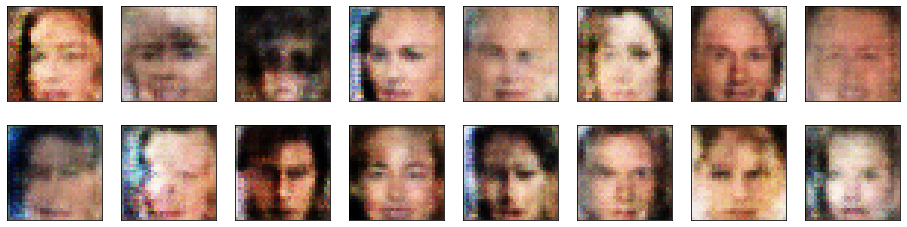

Epoch [    2/    5] | d_loss: 0.1606 | g_loss: 0.9242
Epoch [    2/    5] | d_loss: 0.1439 | g_loss: 0.9360
Epoch [    2/    5] | d_loss: 0.1604 | g_loss: 0.9361
Epoch [    2/    5] | d_loss: 0.1232 | g_loss: 0.9485
Epoch [    2/    5] | d_loss: 0.1195 | g_loss: 0.9639
Epoch [    2/    5] | d_loss: 0.1156 | g_loss: 0.9669
Epoch [    2/    5] | d_loss: 0.1125 | g_loss: 0.9657
Epoch [    2/    5] | d_loss: 0.1123 | g_loss: 0.9714
Epoch [    2/    5] | d_loss: 0.0890 | g_loss: 0.9784
Epoch [    2/    5] | d_loss: 0.0287 | g_loss: 0.9855
Epoch [    2/    5] | d_loss: 0.0888 | g_loss: 0.9844
Epoch [    2/    5] | d_loss: 0.1242 | g_loss: 0.9772
Epoch [    2/    5] | d_loss: 0.0389 | g_loss: 0.9873
Epoch [    2/    5] | d_loss: 0.0333 | g_loss: 0.9892
Epoch [    2/    5] | d_loss: 0.1727 | g_loss: 0.9755
Epoch [    2/    5] | d_loss: 0.0989 | g_loss: 0.9811
Epoch [    2/    5] | d_loss: 0.0204 | g_loss: 0.9888
Epoch [    2/    5] | d_loss: 0.0284 | g_loss: 0.9890
Epoch [    2/    5] | d_loss

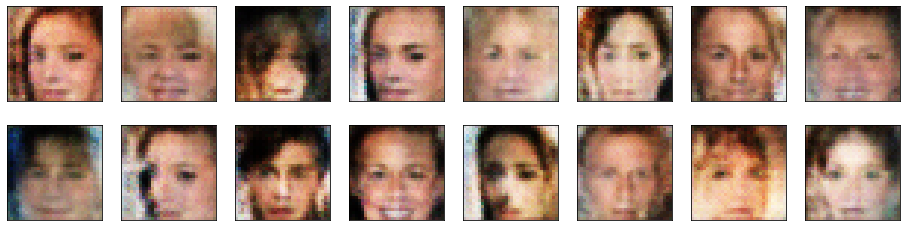

Epoch [    3/    5] | d_loss: 0.0508 | g_loss: 0.9899
Epoch [    3/    5] | d_loss: 0.8021 | g_loss: 0.9329
Epoch [    3/    5] | d_loss: 0.9968 | g_loss: 0.9086
Epoch [    3/    5] | d_loss: 0.5458 | g_loss: 0.7280
Epoch [    3/    5] | d_loss: 0.0171 | g_loss: 0.9800
Epoch [    3/    5] | d_loss: 0.0088 | g_loss: 0.9887
Epoch [    3/    5] | d_loss: 0.7885 | g_loss: 0.9981
Epoch [    3/    5] | d_loss: 0.9993 | g_loss: 0.9479
Epoch [    3/    5] | d_loss: 0.7767 | g_loss: 0.6811
Epoch [    3/    5] | d_loss: 0.3746 | g_loss: 0.9235
Epoch [    3/    5] | d_loss: 0.8102 | g_loss: 0.7093
Epoch [    3/    5] | d_loss: 0.1799 | g_loss: 0.9282
Epoch [    3/    5] | d_loss: 0.0812 | g_loss: 0.9721
Epoch [    3/    5] | d_loss: 0.2230 | g_loss: 0.9737
Epoch [    3/    5] | d_loss: 0.0501 | g_loss: 0.9753
Epoch [    3/    5] | d_loss: 0.1038 | g_loss: 0.9820
Epoch [    3/    5] | d_loss: 0.0570 | g_loss: 0.9828
Epoch [    3/    5] | d_loss: 0.0632 | g_loss: 0.9949
Epoch [    3/    5] | d_loss

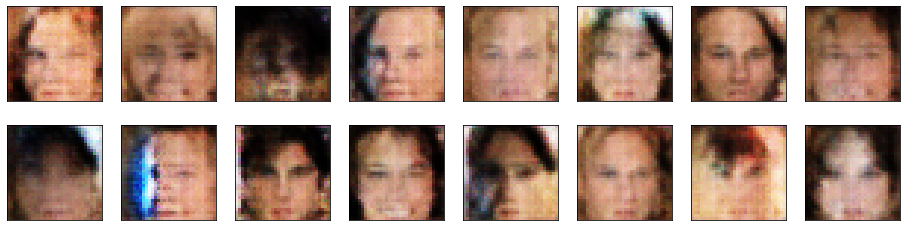

Epoch [    4/    5] | d_loss: 0.2947 | g_loss: 0.9776
Epoch [    4/    5] | d_loss: 0.1957 | g_loss: 0.9638
Epoch [    4/    5] | d_loss: 0.2327 | g_loss: 0.9675
Epoch [    4/    5] | d_loss: 0.2581 | g_loss: 0.9504
Epoch [    4/    5] | d_loss: 0.0430 | g_loss: 0.9866
Epoch [    4/    5] | d_loss: 0.0701 | g_loss: 0.9921
Epoch [    4/    5] | d_loss: 0.9170 | g_loss: 0.8082
Epoch [    4/    5] | d_loss: 0.1772 | g_loss: 0.8885
Epoch [    4/    5] | d_loss: 0.0284 | g_loss: 0.9753
Epoch [    4/    5] | d_loss: 0.0446 | g_loss: 0.9867
Epoch [    4/    5] | d_loss: 0.5815 | g_loss: 0.9518
Epoch [    4/    5] | d_loss: 0.0242 | g_loss: 0.9657
Epoch [    4/    5] | d_loss: 0.0127 | g_loss: 0.9940
Epoch [    4/    5] | d_loss: 0.0309 | g_loss: 0.9856
Epoch [    4/    5] | d_loss: 0.3992 | g_loss: 0.9239
Epoch [    4/    5] | d_loss: 0.2813 | g_loss: 0.9012
Epoch [    4/    5] | d_loss: 0.5348 | g_loss: 0.8994
Epoch [    4/    5] | d_loss: 0.0840 | g_loss: 0.9633
Epoch [    4/    5] | d_loss

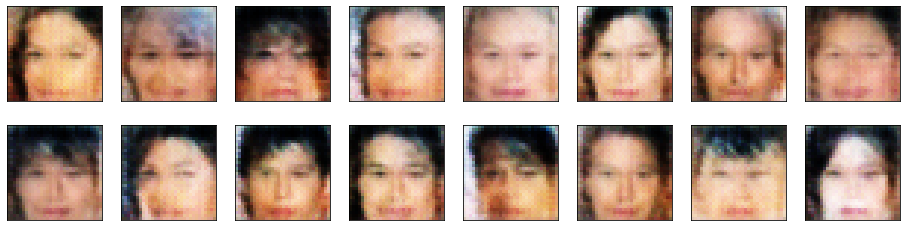

Epoch [    5/    5] | d_loss: 0.3420 | g_loss: 0.9361
Epoch [    5/    5] | d_loss: 0.6442 | g_loss: 0.4841
Epoch [    5/    5] | d_loss: 0.2146 | g_loss: 0.9125
Epoch [    5/    5] | d_loss: 0.1013 | g_loss: 0.9566
Epoch [    5/    5] | d_loss: 0.0440 | g_loss: 0.9714
Epoch [    5/    5] | d_loss: 0.0357 | g_loss: 0.9899
Epoch [    5/    5] | d_loss: 0.1331 | g_loss: 0.9838
Epoch [    5/    5] | d_loss: 0.1158 | g_loss: 0.9758
Epoch [    5/    5] | d_loss: 0.1743 | g_loss: 0.9755
Epoch [    5/    5] | d_loss: 0.1385 | g_loss: 0.9630
Epoch [    5/    5] | d_loss: 0.1316 | g_loss: 0.9610
Epoch [    5/    5] | d_loss: 0.0185 | g_loss: 0.9900
Epoch [    5/    5] | d_loss: 0.0004 | g_loss: 0.9958
Epoch [    5/    5] | d_loss: 0.2691 | g_loss: 0.9642
Epoch [    5/    5] | d_loss: 0.0274 | g_loss: 0.9721
Epoch [    5/    5] | d_loss: 0.0148 | g_loss: 0.9874
Epoch [    5/    5] | d_loss: 0.2662 | g_loss: 0.9777
Epoch [    5/    5] | d_loss: 0.7574 | g_loss: 0.5719
Epoch [    5/    5] | d_loss

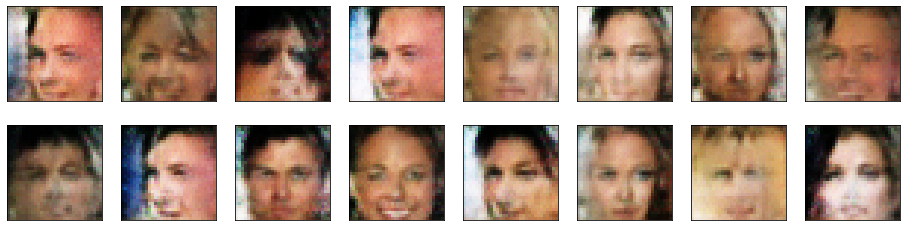

In [21]:
# set number of epochs 
n_epochs = 5


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs, print_every=37)

In [22]:
# Let's do some more epochs and see what happens...

# losses = train(D, G, n_epochs=20, print_every=100)

In [23]:
# Let's do a bit more training with slightly increased learning rate for D.
# I'm seeing from the losses above that D is struggling a bit more than it should to be fully useful for G's training.

# d_optimizer = optim.Adam(D.parameters(),lr=0.000075,betas=(0.5,0.999))
# g_optimizer = optim.Adam(G.parameters(),lr=0.000100,betas=(0.5,0.999))
# losses = train(D, G, n_epochs=10, print_every=100)

In [24]:
torch.save(D.state_dict(),'D_state_dict'+run_id+'.pt')
torch.save(G.state_dict(),'G_state_dict'+run_id+'.pt')

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

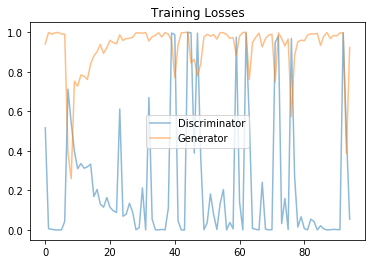

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
with open('losses'+run_id+'.pkl', 'wb') as f:
    pkl.dump(losses, f)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples'+run_id+'.pkl', 'rb') as f:
    samples = pkl.load(f)

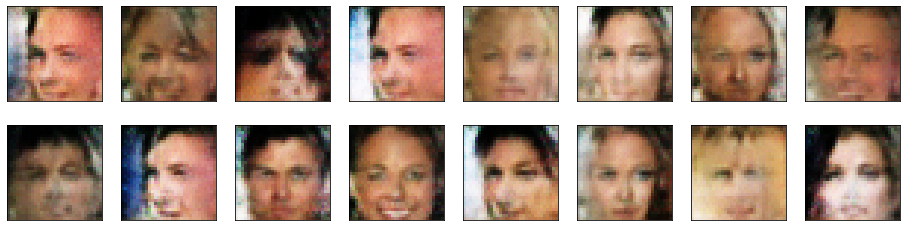

In [28]:
 _ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

My first run involved 100 epochs with a learning rate of 0.0002 for both D and G, and with a fully connected layer in G that linearly maps latent vectors into the first convolutional layer. The model was doing okay and making vaguely face-like things for the first 40/100 epochs, but then the model started to forget everything it had learned! By epoch 100, it was generating much worse results than the 10th epoch! I think this is [catastrophic forgetting](https://arxiv.org/abs/1807.04015). I also had the issue of mode collapse during epochs 1-40, and the paper I just linked did have some useful advice on both counts:
- Don't have a fully connect layer! Their weight matrices tend to gradually lose rank (or approximate rank), and this encourages mode collapse. Convolutional weight matrices are much more immune to this for reasons explained in the paper.
- If the discriminator gets too good at its job, it can becomes a bad critic for the discriminator and will never help it to improve.

So I got rid of the fully connected layer and decided to just make my first convolutional layer consist of latent space coordinates directly. And I used a different learning rate for the discriminator to slow it down a bit, so that the generator has time to benefit from it before it takes off and becomes too good.

How could I improve my model? Well I don't think there's any problem (at least not a _machine learning_ problem) with it generating mostly white faces-- that's just the distribution that it learned from and that means it's doing a good job at discovering that distribution. However if it generates _only_ white faces then we have a problem, since the generator is fooling the discriminator by only concentrating its outputs on _some of the modes_ of the data distribution, rather than capturing the finer details of the distribution.

TODO:
- LOOK FOR BLACK FACES
- Play with G below
- delete the extraneous commented out cells of additional training if there are any left.
- Describe unrolling idea if it worked out...

I think a good improvement would be to generate higher quality images-- like 64 by 64 images. This might require a deeper model, which I think I could try out by increasing the number of residual blocks (the n_res parameter) in my G and D.

As for optimization strategy, automating the system of dynamically chosen learning rates could be very useful here. The generator was improving for the first few epochs, but things became pretty unstable after that. It would be interesting to try and adjust learning rates dynamically so that neither D nor G is allowed to remain too powerful for too many training steps. 

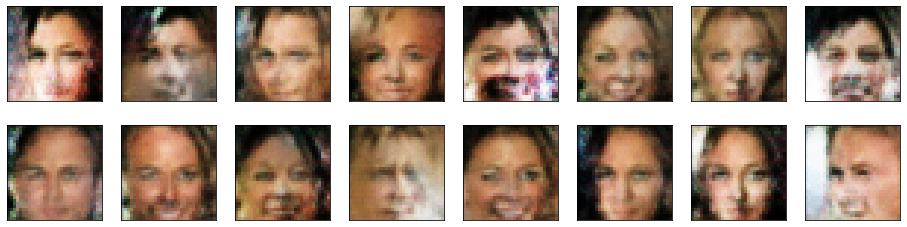

In [68]:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
# move z to GPU if available
if train_on_gpu:
    fixed_z = fixed_z.cuda()

G.eval()
view_sample(G(fixed_z))

In [30]:
# racial_diversity_latent_vectors = []

In [31]:
# I kept re-running this cell trying to collect certain faces
# racial_diversity_latent_vectors.append(fixed_z[0].cpu().numpy())

In [32]:
# with open('some_latent_points'+run_id+'.pkl', 'wb') as f:
#     pkl.dump(racial_diversity_latent_vectors, f)

In [33]:
G.eval()
view_sample(G(torch.Tensor(racial_diversity_latent_vectors).cuda()))

NameError: name 'racial_diversity_latent_vectors' is not defined

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.